# Imports and Functions

In [37]:
from sunlab.environment.base.cpu import *
from sunlab.environment.base.extras import *
from sunlab.globals import FILES
from sunlab.sunflow import *

In [38]:
from matplotlib import transforms
from sklearn.neighbors import KDTree
_rot_t = lambda deg: transforms.Affine2D().rotate_deg(deg)

In [39]:
def proximity_to(dest_arr, src, R=0.15):
    assert src.shape[-1] == dest_arr.shape[-1], f"Shape Mismatch! {src.shape}, {dest_arr.shape}"
    arrs = []
    for row in dest_arr:
        if np.linalg.norm(src-row) < R:
            arrs.append(row)
    return np.array(arrs)

def dotProduct(a,b, norm=False, axis=-1):
    if norm:
        return np.sum(a*b,axis=axis)/(np.linalg.norm(a,axis=axis)*np.linalg.norm(b,axis=axis))
    return np.sum(a*b, axis=axis)

def DistanceCovariance(model, mfv_dataset, labels=None, shuffle=False, silent=False):
    """# Distance Covariance
    Compute the distance in the MFS and MLS
    - mfv_dataset: (N,13)
    - labels: (N,...) ?"""
    from numpy import vstack, array
    from numpy.linalg import norm
    from tqdm.auto import tqdm
    assert mfv_dataset.shape[1] == 13
    if labels is None:
        neighborhood_labels = None
    else:
        assert labels.shape[0] == mfv_dataset.shape[0]
        neighborhood_labels = []
    neighborhood_distances = []
    progress = tqdm
    if silent:
        progress = lambda x: x
    for cell_index in progress(range(mfv_dataset.shape[0])):
        source_cell = mfv_dataset[[cell_index],:]
        destination_cells = vstack([mfv_dataset[:cell_index,:], mfv_dataset[(cell_index+1):,:]])
        mfv_distance = norm((destination_cells - source_cell), axis=-1)
        mlv_distance = norm((model.encoder(destination_cells)-model.encoder(source_cell)), axis=-1)
        v_distances = list(zip(mfv_distance, mlv_distance))
        if labels is not None:
            neighborhood_labels.extend([labels[cell_index,...]] * len(v_distances))
        for distance in v_distances:
            neighborhood_distances.append(distance)
    neighborhood_distances = array(neighborhood_distances)
    if labels is not None:
        neighborhood_labels = array(neighborhood_labels)
    if shuffle:
        from numpy.random import permutation as permute
        permutation = permute(neighborhood_distances.shape[0])
        neighborhood_distances = neighborhood_distances[permutation,...]
        if labels is not None:
            neighborhood_labels = neighborhood_labels[permutation,...]
    return neighborhood_distances, neighborhood_labels

def AngleCovariance(model, mfv_dataset, labels=None, filter_R=0.15, shuffle=False, silent=False):
    """# Angular Covariance
    Compute the angular mapping in the MFS and MLS
    - mfv_dataset: (N,13)
    - labels: (N,...) ?"""
    from numpy import vstack, array, ones_like, clip
    from numpy import min as np_min
    from numpy import max as np_max
    from numpy.linalg import norm
    from tqdm.auto import tqdm
    from warnings import warn
    assert mfv_dataset.shape[1] == 13
    if labels is None:
        neighborhood_labels = None
    else:
        assert labels.shape[0] == mfv_dataset.shape[0]
        neighborhood_labels = []
    neighborhood_dot_products = []
    progress = tqdm
    if silent:
        progress = lambda x: x
    for cell_index in progress(range(mfv_dataset.shape[0])):
        source_cell = mfv_dataset[[cell_index],:]
        for middle_cell_index in range(cell_index+1,mfv_dataset.shape[0]):
            middle_cell = mfv_dataset[[middle_cell_index],:]
            if norm((middle_cell - source_cell)) > filter_R:
                continue
            middle_cell_mlv = model.encoder(middle_cell)
            destination_cells = mfv_dataset[(middle_cell_index+1):,:]
            destination_cells = proximity_to(destination_cells, middle_cell, R=filter_R)
            if destination_cells.shape[0] == 0:
                continue
            comparison_vector = ones_like(destination_cells) * (middle_cell - source_cell)
            source_cell_stacks_mlv = model.encoder(ones_like(destination_cells) * source_cell).numpy()
            destination_cells_mlv = model.encoder(destination_cells).numpy()
            mfv_dot = dotProduct(comparison_vector, (destination_cells - middle_cell), axis=-1, norm=True)
            mlv_dot = dotProduct(middle_cell_mlv - source_cell_stacks_mlv,
                                 destination_cells_mlv - middle_cell_mlv, axis=-1, norm=True)
            v_dot_products = list(zip(mfv_dot, mlv_dot))
            if labels is not None:
                neighborhood_labels.extend([labels[cell_index,...]] * len(v_dot_products))
            for dot_product in v_dot_products:
                neighborhood_dot_products.append(dot_product)
    neighborhood_dot_products = array(neighborhood_dot_products)
    mV, MV = np_min(neighborhood_dot_products), np_max(neighborhood_dot_products)
    if mV < -1:
        warn(f"Found {mV}")
    if MV > 1:
        warn(f"Found {MV}")
    neighborhood_dot_products = clip(neighborhood_dot_products, -1, 1)
    if labels is not None:
        neighborhood_labels = array(neighborhood_labels)
    if shuffle:
        from numpy.random import permutation as permute
        permutation = permute(neighborhood_dot_products.shape[0])
        neighborhood_dot_products = neighborhood_dot_products[permutation,...]
        if labels is not None:
            neighborhood_labels = neighborhood_labels[permutation,...]
    return np.arccos(neighborhood_dot_products), neighborhood_labels

In [40]:
def plot_rectangle(xy_arr, _color='black', _line_width=2):
    if isinstance(xy_arr, list):
        xy_arr = np.array(xy_arr)
    assert xy_arr.shape[-1] == 2, "Must be 2d!"
    _X = xy_arr[...,0].flatten()
    _Y = xy_arr[...,1].flatten()
    plt.plot(_X, _Y, '-', color=_color, lw=_line_width)
    plt.plot([_X[-1],_X[0]], [_Y[-1],_Y[0]], '-', color=_color, lw=_line_width)

def rotate_data(data, theta=0):
    if isinstance(data, list):
        data = np.array(data)
    assert data.shape[-1] == 2, "Must be 2d!"
    T = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return data @ T.T

def extrema(data):
    if isinstance(data, list):
        data = np.array(data)
    assert data.shape[-1] == 2, "Must be 2d!"
    assert len(data.shape) == 2, "Nx2 required"
    return (*np.min(data, axis=0), *np.max(data, axis=0))

def extrema_area(data):
    xmin,ymin,xmax,ymax = extrema(data)
    return (xmax-xmin) * (ymax-ymin)

def bound_extrema(extremes):
    xmin,ymin,xmax,ymax = (*extremes,)
    return np.array([[xmin,ymin],[xmin,ymax],[xmax,ymax],[xmax,ymin]])

def find_min_area_angle(data, _sample=100):
    if isinstance(data, list):
        data = np.array(data)
    assert data.shape[-1] == 2, "Must be 2d!"
    angle_area = []
    for theta in np.linspace(0, np.pi/2, _sample):
        XY = rotate_data(data, theta)
        angle_area.append((theta,extrema_area(XY)))
    angle_area = angle_area
    theta, _ = min(angle_area, key=lambda x: x[1])
    XY = rotate_data(data, theta)
    xmin, ymin, xmax, ymax = extrema(XY)
    if (xmax-xmin) < (ymax - ymin):
        theta += np.pi/2
    return theta

def grid_smallest_rectangle(data, _grid_n=500, _sample_theta=100, _return_theta=False):
    if isinstance(data, list):
        data = np.array(data)
    assert data.shape[-1] == 2, "Must be 2d!"
    theta = find_min_area_angle(data, _sample=_sample_theta)
    _data = rotate_data(data, theta)
    xmin,ymin,xmax,ymax = extrema(_data)
    _grid_x = 0
    _grid_y = 0
    if isinstance(_grid_n, list):
        assert len(_grid_n) == 2, "Must be [x_n,y_n]"
        _grid_x = _grid_n[0]
        _grid_y = _grid_n[1]
    elif isinstance(_grid_n, np.ndarray):
        assert _grid_n.shape[0] == 2, "Must be [x_n,y_n]"
        assert len(_grid_n.shape) == 1, "Must be [x_n,y_n]"
        _grid_x = _grid_n[0]
        _grid_y = _grid_n[1]
    else:
        _grid_x = _grid_n
        _grid_y = _grid_n
    X,Y = np.meshgrid(np.linspace(xmin, xmax, _grid_x), np.linspace(ymin, ymax, _grid_y))
    XY = np.array([X,Y])
    if _return_theta:
        return rotate_data(XY.transpose(1,2,0), -theta).transpose(2,0,1), theta
    return rotate_data(XY.transpose(1,2,0), -theta).transpose(2,0,1)

In [41]:
model = load_aae(FILES['PRETRAINED_MODEL_DIR'], MaxAbsScaler)

In [42]:
%%capture

CN03_DATASET_FNAMES = FILES['CN03'].values()
CN03_datasets, CN03_dataframe = process_and_load_datasets(CN03_DATASET_FNAMES,
                                                          FILES['PRETRAINED_MODEL_DIR'],
                                                          magnification=20)
CN03_DATASET_NAME = "CN03"

In [43]:
%%capture

Y27632_DATASET_FNAMES = FILES['Y27632'].values()
Y27632_datasets, Y27632_dataframe = process_and_load_datasets(Y27632_DATASET_FNAMES,
                                                              FILES['PRETRAINED_MODEL_DIR'],
                                                              magnification=20)
Y27632_DATASET_NAME = "Y27632"

# Runtime Parameters

In [72]:
SAVE_EXTRAS = False

In [45]:
g_NearestK = 10
g_ArrowSize = 0.4#0.1
g_FilterR = 0.15
g_Subsample = 250
g_Datasets = ['CN03', 'Y27632']
g_Base = lambda index: DIR_ROOT + f"Figures/DrugTreatment/{g_Datasets[index]}/"

# Results

## Angles

### CN03

#### Setup

In [46]:
CN03_dataset = np.vstack(map(lambda x: x.dataset, CN03_datasets))
CN03_label = np.vstack(map(lambda x: x.labels[...,np.newaxis], CN03_datasets))

permute = np.random.permutation(CN03_dataset.shape[0])[:g_Subsample]
CN03_subsampled = (CN03_dataset[permute,:],CN03_label[permute,:])

CN03_dataset = CN03_subsampled[0]
CN03_label = CN03_subsampled[1]

print(CN03_dataset.shape, CN03_label.shape)
CN03_angles, CN03_labels = AngleCovariance(model, CN03_dataset, CN03_label, shuffle=True, filter_R=g_FilterR)

(250, 13) (250, 1)


/tmp/4098278.4.sun-gpu.q/ipykernel_14231/2826200175.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  CN03_dataset = np.vstack(map(lambda x: x.dataset, CN03_datasets))
/tmp/4098278.4.sun-gpu.q/ipykernel_14231/2826200175.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  CN03_label = np.vstack(map(lambda x: x.labels[...,np.newaxis], CN03_datasets))


  0%|          | 0/250 [00:00<?, ?it/s]

/tmp/4098278.4.sun-gpu.q/ipykernel_14231/3143707416.py:99: UserWarning: Found -1.0000001192092896
  warn(f"Found {mV}")
/tmp/4098278.4.sun-gpu.q/ipykernel_14231/3143707416.py:101: UserWarning: Found 1.0000001192092896
  warn(f"Found {MV}")


#### Plots

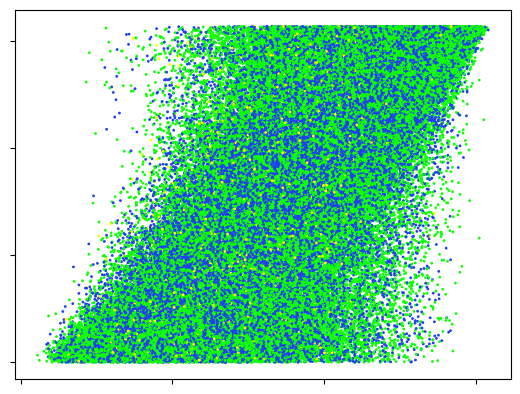

In [47]:
plt.scatter2d(CN03_angles, s=1, c=CN03_labels, cmap=Pmap)
if SAVE_EXTRAS:
    plt.save(g_Base(0) + "Angles/" + "Colored", _xticks=True, _yticks=True, tighten=False)

### Y27632

#### Setup

In [48]:
Y27632_dataset = np.vstack(map(lambda x: x.dataset, Y27632_datasets))
Y27632_label = np.vstack(map(lambda x: x.labels[...,np.newaxis], Y27632_datasets))

permute = np.random.permutation(Y27632_dataset.shape[0])[:g_Subsample]
Y27632_subsampled = (Y27632_dataset[permute,:],Y27632_label[permute,:])

Y27632_dataset = Y27632_subsampled[0]
Y27632_label = Y27632_subsampled[1]
print(Y27632_dataset.shape, Y27632_label.shape)
Y27632_angles, Y27632_labels = AngleCovariance(model, Y27632_dataset, Y27632_label, shuffle=True, filter_R=g_FilterR)

(250, 13) (250, 1)


/tmp/4098278.4.sun-gpu.q/ipykernel_14231/363036622.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Y27632_dataset = np.vstack(map(lambda x: x.dataset, Y27632_datasets))
/tmp/4098278.4.sun-gpu.q/ipykernel_14231/363036622.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Y27632_label = np.vstack(map(lambda x: x.labels[...,np.newaxis], Y27632_datasets))


  0%|          | 0/250 [00:00<?, ?it/s]

/tmp/4098278.4.sun-gpu.q/ipykernel_14231/3143707416.py:101: UserWarning: Found 1.0000001192092896
  warn(f"Found {MV}")


#### Plots

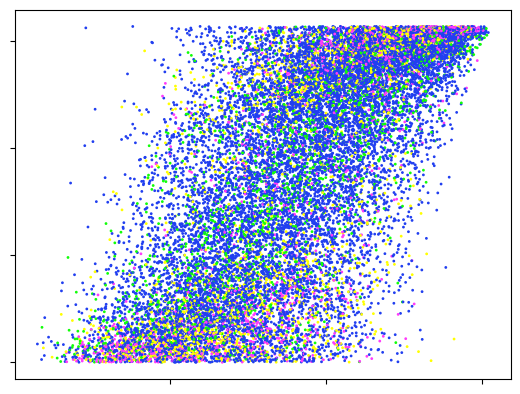

In [49]:
plt.scatter2d(Y27632_angles, s=1, c=Y27632_labels, cmap=Pmap)
if SAVE_EXTRAS:
    plt.save(g_Base(1) + "Angles/" + "Colored", _xticks=True, _yticks=True, tighten=False)

## Distances

### CN03

#### Setup

In [50]:
CN03_dataset = np.vstack(map(lambda x: x.dataset, CN03_datasets))
CN03_label = np.vstack(map(lambda x: x.labels[...,np.newaxis], CN03_datasets))
print(CN03_dataset.shape, CN03_label.shape)
CN03_distances, CN03_labels = DistanceCovariance(model, CN03_dataset, CN03_label, shuffle=True)

(857, 13) (857, 1)


/tmp/4098278.4.sun-gpu.q/ipykernel_14231/2068331347.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  CN03_dataset = np.vstack(map(lambda x: x.dataset, CN03_datasets))
/tmp/4098278.4.sun-gpu.q/ipykernel_14231/2068331347.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  CN03_label = np.vstack(map(lambda x: x.labels[...,np.newaxis], CN03_datasets))


  0%|          | 0/857 [00:00<?, ?it/s]

#### Plots

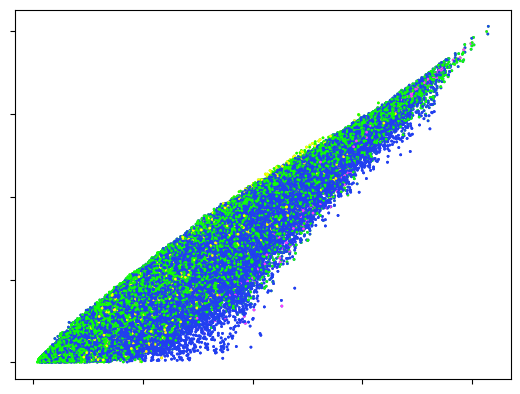

In [51]:
plt.scatter2d(CN03_distances, s=1, c=CN03_labels, cmap=Pmap)
if SAVE_EXTRAS:
    plt.save(g_Base(0) + "Distances/" + "Colored", _xticks=True, _yticks=True, tighten=False)

### Y27632

#### Setup

In [52]:
Y27632_dataset = np.vstack(map(lambda x: x.dataset, Y27632_datasets))
Y27632_label = np.vstack(map(lambda x: x.labels[...,np.newaxis], Y27632_datasets))
print(Y27632_dataset.shape, Y27632_label.shape)
Y27632_distances, Y27632_labels = DistanceCovariance(model, Y27632_dataset, Y27632_label, shuffle=True)

(619, 13) (619, 1)


/tmp/4098278.4.sun-gpu.q/ipykernel_14231/583499096.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Y27632_dataset = np.vstack(map(lambda x: x.dataset, Y27632_datasets))
/tmp/4098278.4.sun-gpu.q/ipykernel_14231/583499096.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Y27632_label = np.vstack(map(lambda x: x.labels[...,np.newaxis], Y27632_datasets))


  0%|          | 0/619 [00:00<?, ?it/s]

#### Plots

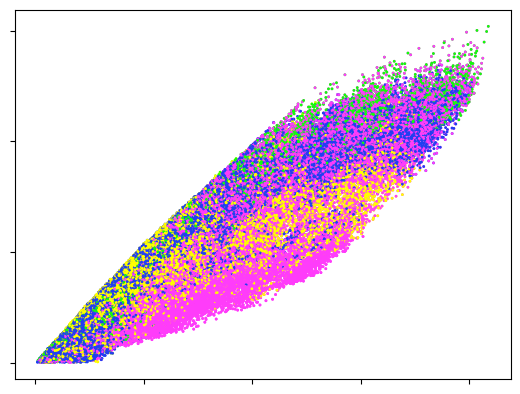

In [53]:
plt.scatter2d(Y27632_distances, s=1, c=Y27632_labels, cmap=Pmap)
if SAVE_EXTRAS:
    plt.save(g_Base(1) + "Distances/" + "Colored", _xticks=True, _yticks=True, tighten=False)

## Flow Fields

### CN03

#### Setup

In [54]:
CN03_GRID, CN03_THETA = grid_smallest_rectangle(CN03_dataframe[['Latent-0','Latent-1']].to_numpy(), 50, _return_theta=True)

In [55]:
CN03_TRAJECTORY_DATAFRAME = pd.DataFrame(columns=['Latent-0','Latent-1','Latent-UV0','Latent-UV1','Frame','CellNum'])
for index,_DATASET in enumerate(CN03_datasets):
    dataframe = _DATASET.dataframe
    df = dataframe.copy()[['Latent-0','Latent-1','Frames']]
    df_n = df.to_numpy()
    for N in range(df_n.shape[0]-1):
        CN03_TRAJECTORY_DATAFRAME = pd.concat([CN03_TRAJECTORY_DATAFRAME,pd.DataFrame.from_dict({
            "Latent-0": [df_n[N,0]],
            "Latent-1": [df_n[N,1]],
            "Latent-UV0": [df_n[N+1,0] - df_n[N,0]],
            "Latent-UV1": [df_n[N+1,1] - df_n[N,1]],
            "Frame": [df_n[N,2]],
            "CellNum": [index],
        })])

In [56]:
CN03_TRAJECTORY_DATAFRAME

,Latent-0,Latent-1,Latent-UV0,Latent-UV1,Frame,CellNum
0,1.846227,-0.544856,-0.007764,-0.053792,1.0,0
0,1.838462,-0.598648,-1.049746,0.244867,2.0,0
0,0.788716,-0.353781,-0.045017,0.047308,3.0,0
0,0.7437,-0.306473,0.073263,-0.097971,4.0,0
0,0.816963,-0.404444,-0.15839,0.040007,5.0,0
...,...,...,...,...,...,...
0,2.770348,-0.929611,-0.123638,-0.08698,100.0,7
0,2.646709,-1.016591,-0.314632,0.178689,101.0,7
0,2.332078,-0.837903,-0.100606,0.006705,102.0,7
0,2.231471,-0.831198,-0.300963,0.094116,103.0,7


In [57]:
CN03_tree = KDTree(CN03_TRAJECTORY_DATAFRAME[['Latent-0','Latent-1']])

In [58]:
COLUMNS = ['Latent-UV0','Latent-UV1',  'Frame', 'CellNum']
CN03_GRID_DATA = np.zeros((len(COLUMNS),CN03_GRID.shape[1],CN03_GRID.shape[2]))
_df = CN03_TRAJECTORY_DATAFRAME.copy()[COLUMNS].to_numpy()
for index in range(CN03_GRID.shape[1]):
    for indey in range(CN03_GRID.shape[2]):
        point = CN03_GRID[:,index,indey][np.newaxis,:]
        other_distances, other_points = CN03_tree.query(point, k=g_NearestK)
        mean_data = np.mean(_df[other_points.squeeze()], axis=0)
        mean_data = np.average(_df[other_points.squeeze()], axis=0, weights=(-other_distances).squeeze())
        for index_data in range(mean_data.shape[0]):
            CN03_GRID_DATA[index_data, index, indey] = mean_data[index_data]

#### Plots

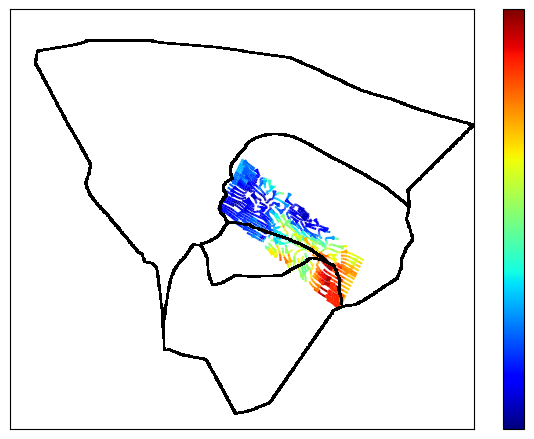

In [59]:
base = plt.gca().transData
_GRID = rotate_data(CN03_GRID.transpose(1,2,0), CN03_THETA).transpose(2,0,1)
_GRID_DATA = rotate_data(CN03_GRID_DATA[0:2,...].transpose(1,2,0), CN03_THETA).transpose(2,0,1)
plt.streamplot(_GRID[0,...], _GRID[1,...], _GRID_DATA[0,...], _GRID_DATA[1,...], color=CN03_GRID_DATA[2,...],
               cmap='jet', transform=_rot_t(-CN03_THETA*180/np.pi) +base, zorder=-2, arrowsize=g_ArrowSize)
plt.colorbar()
# plt.scatter('Latent-0','Latent-1',color='black',data=_TRAJECTORY_DATAFRAME, s=0.1, alpha=0.2, zorder=4)
# plt.pcolor(GRID[0,...],GRID[1,...],GRID_DATA[2,...], cmap='jet')
plt.apply_boundary()
# xmin,ymin,xmax,ymax = extrema(CN03_GRID.transpose(1,2,0).reshape((-1,2)))
# plt.xlim([xmin,xmax])
# plt.ylim([ymin,ymax])

if SAVE_EXTRAS:
    plt.save(g_Base(0) + "FlowFields/" + "Full_Cbar")

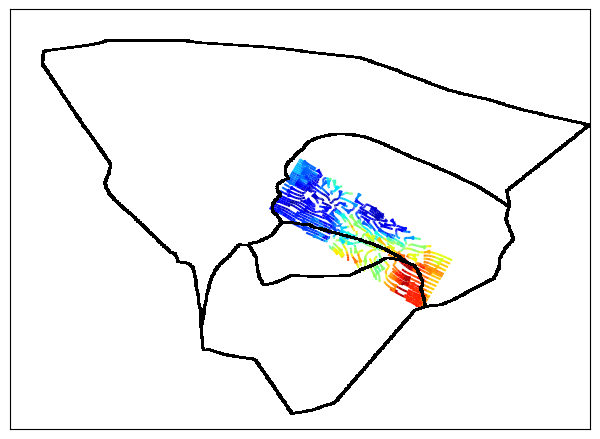

In [60]:
base = plt.gca().transData
_GRID = rotate_data(CN03_GRID.transpose(1,2,0), CN03_THETA).transpose(2,0,1)
_GRID_DATA = rotate_data(CN03_GRID_DATA[0:2,...].transpose(1,2,0), CN03_THETA).transpose(2,0,1)
plt.streamplot(_GRID[0,...], _GRID[1,...], _GRID_DATA[0,...], _GRID_DATA[1,...], color=CN03_GRID_DATA[2,...],
               cmap='jet', transform=_rot_t(-CN03_THETA*180/np.pi) +base, zorder=-2, arrowsize=g_ArrowSize)
# plt.colorbar()
# plt.scatter('Latent-0','Latent-1',color='black',data=_TRAJECTORY_DATAFRAME, s=0.1, alpha=0.2, zorder=4)
# plt.pcolor(GRID[0,...],GRID[1,...],GRID_DATA[2,...], cmap='jet')
plt.apply_boundary()
# xmin,ymin,xmax,ymax = extrema(CN03_GRID.transpose(1,2,0).reshape((-1,2)))
# plt.xlim([xmin,xmax])
# plt.ylim([ymin,ymax])

if SAVE_EXTRAS:
    plt.save(g_Base(0) + "FlowFields/" + "Full_NoCbar")

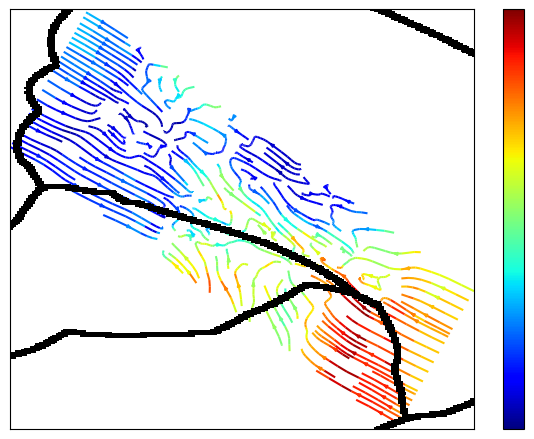

In [61]:
base = plt.gca().transData
_GRID = rotate_data(CN03_GRID.transpose(1,2,0), CN03_THETA).transpose(2,0,1)
_GRID_DATA = rotate_data(CN03_GRID_DATA[0:2,...].transpose(1,2,0), CN03_THETA).transpose(2,0,1)
plt.streamplot(_GRID[0,...], _GRID[1,...], _GRID_DATA[0,...], _GRID_DATA[1,...], color=CN03_GRID_DATA[2,...],
               cmap='jet', transform=_rot_t(-CN03_THETA*180/np.pi) +base, zorder=-2, arrowsize=g_ArrowSize)
plt.colorbar()
# plt.scatter('Latent-0','Latent-1',color='black',data=_TRAJECTORY_DATAFRAME, s=0.1, alpha=0.2, zorder=4)
# plt.pcolor(GRID[0,...],GRID[1,...],GRID_DATA[2,...], cmap='jet')
plt.apply_boundary()
xmin,ymin,xmax,ymax = extrema(CN03_GRID.transpose(1,2,0).reshape((-1,2)))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

if SAVE_EXTRAS:
    plt.save(g_Base(0) + "FlowFields/" + "Zoomed_Cbar")

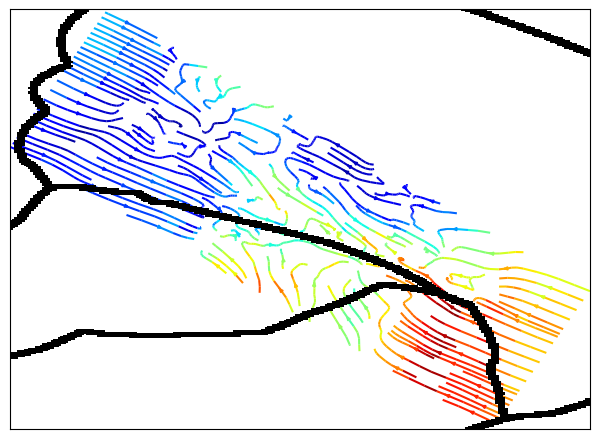

In [62]:
base = plt.gca().transData
_GRID = rotate_data(CN03_GRID.transpose(1,2,0), CN03_THETA).transpose(2,0,1)
_GRID_DATA = rotate_data(CN03_GRID_DATA[0:2,...].transpose(1,2,0), CN03_THETA).transpose(2,0,1)
plt.streamplot(_GRID[0,...], _GRID[1,...], _GRID_DATA[0,...], _GRID_DATA[1,...], color=CN03_GRID_DATA[2,...],
               cmap='jet', transform=_rot_t(-CN03_THETA*180/np.pi) +base, zorder=-2, arrowsize=g_ArrowSize)
# plt.colorbar()
# plt.scatter('Latent-0','Latent-1',color='black',data=_TRAJECTORY_DATAFRAME, s=0.1, alpha=0.2, zorder=4)
# plt.pcolor(GRID[0,...],GRID[1,...],GRID_DATA[2,...], cmap='jet')
plt.apply_boundary()
xmin,ymin,xmax,ymax = extrema(CN03_GRID.transpose(1,2,0).reshape((-1,2)))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

if SAVE_EXTRAS:
    plt.save(g_Base(0) + "FlowFields/" + "Zoomed_NoCbar")

### Y27632

#### Setup

In [63]:
Y27632_GRID, Y27632_THETA = grid_smallest_rectangle(Y27632_dataframe[['Latent-0','Latent-1']].to_numpy(), 50, _return_theta=True)

In [64]:
Y27632_TRAJECTORY_DATAFRAME = pd.DataFrame(columns=['Latent-0','Latent-1','Latent-UV0','Latent-UV1','Frame','CellNum'])
for index,_DATASET in enumerate(Y27632_datasets):
    dataframe = _DATASET.dataframe
    df = dataframe.copy()[['Latent-0','Latent-1','Frames']]
    df_n = df.to_numpy()
    for N in range(df_n.shape[0]-1):
        Y27632_TRAJECTORY_DATAFRAME = pd.concat([Y27632_TRAJECTORY_DATAFRAME,pd.DataFrame.from_dict({
            "Latent-0": [df_n[N,0]],
            "Latent-1": [df_n[N,1]],
            "Latent-UV0": [df_n[N+1,0] - df_n[N,0]],
            "Latent-UV1": [df_n[N+1,1] - df_n[N,1]],
            "Frame": [df_n[N,2]],
            "CellNum": [index],
        })])

In [65]:
Y27632_TRAJECTORY_DATAFRAME

,Latent-0,Latent-1,Latent-UV0,Latent-UV1,Frame,CellNum
0,2.909809,-0.523362,-0.509287,0.199558,1.0,0
0,2.400522,-0.323803,0.490942,-0.317506,2.0,0
0,2.891464,-0.641309,-0.234774,0.145766,3.0,0
0,2.65669,-0.495544,-0.028563,0.046408,4.0,0
0,2.628127,-0.449135,0.47949,-0.183529,5.0,0
...,...,...,...,...,...,...
0,2.48867,0.042686,-0.175895,0.04673,119.0,4
0,2.312775,0.089416,0.063828,-0.109814,120.0,4
0,2.376602,-0.020399,-0.458544,0.41322,121.0,4
0,1.918059,0.392821,0.326759,-0.237928,122.0,4


In [66]:
Y27632_tree = KDTree(Y27632_TRAJECTORY_DATAFRAME[['Latent-0','Latent-1']])

In [67]:
COLUMNS = ['Latent-UV0','Latent-UV1',  'Frame', 'CellNum']
Y27632_GRID_DATA = np.zeros((len(COLUMNS),Y27632_GRID.shape[1],Y27632_GRID.shape[2]))
_df = Y27632_TRAJECTORY_DATAFRAME.copy()[COLUMNS].to_numpy()
for index in range(Y27632_GRID.shape[1]):
    for indey in range(Y27632_GRID.shape[2]):
        point = Y27632_GRID[:,index,indey][np.newaxis,:]
        other_distances, other_points = Y27632_tree.query(point, k=g_NearestK)
        mean_data = np.mean(_df[other_points.squeeze()], axis=0)
        mean_data = np.average(_df[other_points.squeeze()], axis=0, weights=(-other_distances).squeeze())
        for index_data in range(mean_data.shape[0]):
            Y27632_GRID_DATA[index_data, index, indey] = mean_data[index_data]

#### Plots

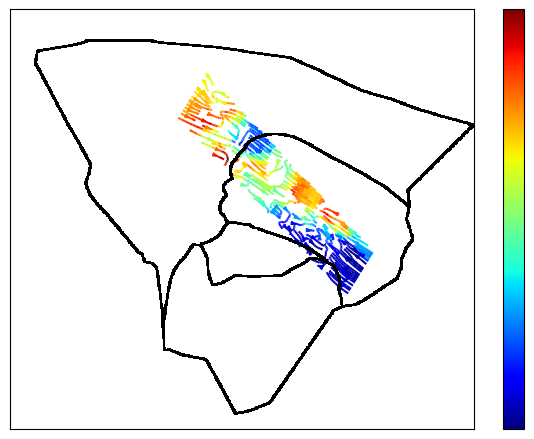

In [68]:
base = plt.gca().transData
_GRID = rotate_data(Y27632_GRID.transpose(1,2,0), Y27632_THETA).transpose(2,0,1)
_GRID_DATA = rotate_data(Y27632_GRID_DATA[0:2,...].transpose(1,2,0), Y27632_THETA).transpose(2,0,1)
plt.streamplot(_GRID[0,...], _GRID[1,...], _GRID_DATA[0,...], _GRID_DATA[1,...], color=Y27632_GRID_DATA[2,...],
               cmap='jet', transform=_rot_t(-Y27632_THETA*180/np.pi) +base, zorder=-2, arrowsize=g_ArrowSize)
plt.colorbar()
# plt.scatter('Latent-0','Latent-1',color='black',data=_TRAJECTORY_DATAFRAME, s=0.1, alpha=0.2, zorder=4)
# plt.pcolor(GRID[0,...],GRID[1,...],GRID_DATA[2,...], cmap='jet')
plt.apply_boundary()
# xmin,ymin,xmax,ymax = extrema(Y27632_GRID.transpose(1,2,0).reshape((-1,2)))
# plt.xlim([xmin,xmax])
# plt.ylim([ymin,ymax])

if SAVE_EXTRAS:
    plt.save(g_Base(1) + "FlowFields/" + "Full_Cbar")

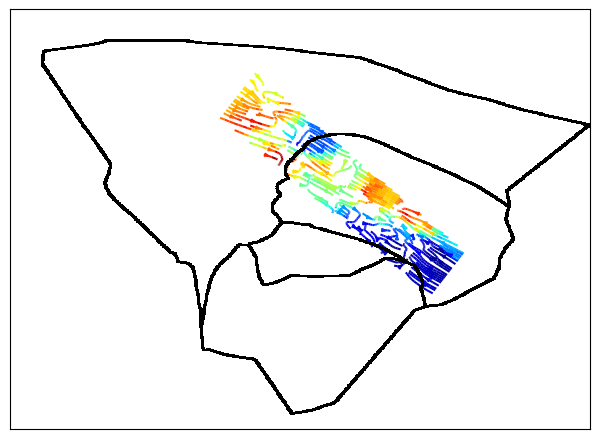

In [69]:
base = plt.gca().transData
_GRID = rotate_data(Y27632_GRID.transpose(1,2,0), Y27632_THETA).transpose(2,0,1)
_GRID_DATA = rotate_data(Y27632_GRID_DATA[0:2,...].transpose(1,2,0), Y27632_THETA).transpose(2,0,1)
plt.streamplot(_GRID[0,...], _GRID[1,...], _GRID_DATA[0,...], _GRID_DATA[1,...], color=Y27632_GRID_DATA[2,...],
               cmap='jet', transform=_rot_t(-Y27632_THETA*180/np.pi) +base, zorder=-2, arrowsize=g_ArrowSize)
# plt.colorbar()
# plt.scatter('Latent-0','Latent-1',color='black',data=_TRAJECTORY_DATAFRAME, s=0.1, alpha=0.2, zorder=4)
# plt.pcolor(GRID[0,...],GRID[1,...],GRID_DATA[2,...], cmap='jet')
plt.apply_boundary()
# xmin,ymin,xmax,ymax = extrema(Y27632_GRID.transpose(1,2,0).reshape((-1,2)))
# plt.xlim([xmin,xmax])
# plt.ylim([ymin,ymax])

if SAVE_EXTRAS:
    plt.save(g_Base(1) + "FlowFields/" + "Full_NoCbar")

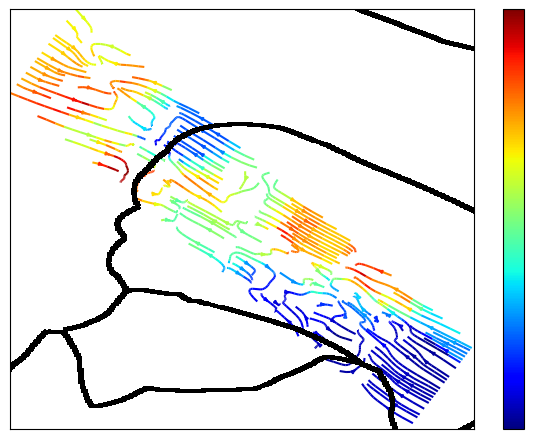

In [70]:
base = plt.gca().transData
_GRID = rotate_data(Y27632_GRID.transpose(1,2,0), Y27632_THETA).transpose(2,0,1)
_GRID_DATA = rotate_data(Y27632_GRID_DATA[0:2,...].transpose(1,2,0), Y27632_THETA).transpose(2,0,1)
plt.streamplot(_GRID[0,...], _GRID[1,...], _GRID_DATA[0,...], _GRID_DATA[1,...], color=Y27632_GRID_DATA[2,...],
               cmap='jet', transform=_rot_t(-Y27632_THETA*180/np.pi) +base, zorder=-2, arrowsize=g_ArrowSize)
plt.colorbar()
# plt.scatter('Latent-0','Latent-1',color='black',data=_TRAJECTORY_DATAFRAME, s=0.1, alpha=0.2, zorder=4)
# plt.pcolor(GRID[0,...],GRID[1,...],GRID_DATA[2,...], cmap='jet')
plt.apply_boundary()
xmin,ymin,xmax,ymax = extrema(Y27632_GRID.transpose(1,2,0).reshape((-1,2)))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

if SAVE_EXTRAS:
    plt.save(g_Base(1) + "FlowFields/" + "Zoomed_Cbar")

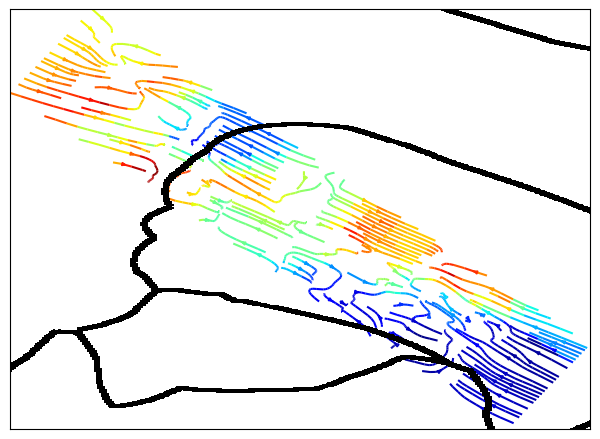

In [71]:
base = plt.gca().transData
_GRID = rotate_data(Y27632_GRID.transpose(1,2,0), Y27632_THETA).transpose(2,0,1)
_GRID_DATA = rotate_data(Y27632_GRID_DATA[0:2,...].transpose(1,2,0), Y27632_THETA).transpose(2,0,1)
plt.streamplot(_GRID[0,...], _GRID[1,...], _GRID_DATA[0,...], _GRID_DATA[1,...], color=Y27632_GRID_DATA[2,...],
               cmap='jet', transform=_rot_t(-Y27632_THETA*180/np.pi) +base, zorder=-2, arrowsize=g_ArrowSize)
# plt.colorbar()
# plt.scatter('Latent-0','Latent-1',color='black',data=_TRAJECTORY_DATAFRAME, s=0.1, alpha=0.2, zorder=4)
# plt.pcolor(GRID[0,...],GRID[1,...],GRID_DATA[2,...], cmap='jet')
plt.apply_boundary()
xmin,ymin,xmax,ymax = extrema(Y27632_GRID.transpose(1,2,0).reshape((-1,2)))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

if SAVE_EXTRAS:
    plt.save(g_Base(1) + "FlowFields/" + "Zoomed_NoCbar")

# END